In [ ]:
library(Seurat)
library(dplyr)
library(ggplot2)
library(tidyverse)
library(patchwork)
library(harmony)
library(readxl)
library(viridis)
library(scMetabolism)

options(warn = -1)
library(future)
availableCores()
options(future.globals.maxSize = 50 * 1024^4)
plan("multicore", workers = 30)

source('/data/work/01.script/HELP/seurat_help.r/cluster_proportion_trend.R')
source('/data/work/01.script/HELP/seurat_help.r/multi_cluster_volcano.R')
source('/data/work/01.script/HELP/seurat_help.r/plot_volcano.R')
source('/data/work/01.script/HELP/seurat_help.r/Sankey_bar.R')

## function & color

In [2]:
colorlist = c("#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941","#006FA6", "#A30059", "#FFE4E1", "#0000A6", "#63FFAC","#B79762", "#004D43", "#8FB0FF", 
              "#997D87", "#5A0007","#809693", "#1B4400", "#4FC601", "#3B5DFF", "#FF2F80","#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9","#B903AA", 
              "#DDEFFF", "#7B4F4B", "#A1C299", "#0AA6D8","#00A087FF", "#4DBBD5FF", "#E64B35FF", "#3C5488FF", "#F38400","#A1CAF1", "#C2B280", "#848482", 
              "#E68FAC", "#0067A5","#F99379", "#604E97", "#F6A600", "#B3446C", "#DCD300","#882D17", "#8DB600", "#654522", "#E25822", "#2B3D26","#191970", 
              "#000080","#6495ED", "#1E90FF", "#00BFFF", "#00FFFF", "#FF1493","#FF00FF", "#A020F0", "#63B8FF", "#008B8B", "#54FF9F","#00FF00", "#76EE00", "#FFF68F")

# if (length(Cells(combined))>60000) {
#     draw_obj = subset(combined, cells=sample(Cells(combined), 50000))
# } else {
#     draw_obj = combined
# }

plots <- function(obj, group_name, prefix, ...){
    
    colors = colorlist[1:length(unique(obj@meta.data[[group_name]]))]
    names(colors) = unique(obj@meta.data[[group_name]])
    
    p <- DimPlot(obj, group.by=group_name, pt.size=0.1, label.size = 8, cols=colors, raster=F, ...)
    print(p)
    ggsave(paste0(prefix, "_", group_name, ".png"),width=15,height=14, dpi = 300)
    
}

plots_split <- function(obj, draw_obj, group_name, prefix, ...){
    
    if (length(Cells(obj))>60000) {
    draw_obj = subset(obj, cells=sample(Cells(obj), 50000))
    } else {
        draw_obj = obj
    }
    
    colors = colorlist[1:length(unique(obj@meta.data[[group_name]]))]
    names(colors) = unique(obj@meta.data[[group_name]])
    
    pdf(paste0(prefix, "_", group_name, "_split.pdf"))
    for (i in sort(unique(draw_obj@meta.data[[group_name]]))){
        cells = Cells(draw_obj)[draw_obj@meta.data[[group_name]]==i]
        p <- DimPlot(draw_obj, group.by=group_name, cells.highlight=cells)
        print(p+ggtitle(i))
    }
    dev.off()
}

In [3]:
cor_sub = c( "Epithelial Cell" = "#DC050C" ,"Alveolar Epithelial Cell" = "#FC0080","Ciliated Cell"="#FB6496", #红色系
              "T_NK Cell" = "#8126C0", "B Cell" = "#00A3D0", "Macrophage" = "#FE9B00", "Mast Cell" = "#814A19",
              "Fibroblast" = "#00A84E", "CAF" = "#5CBD92","Endothelial Cell" = '#FDAF91FF')

cor_main = c("Epithelial Cell" = "#DC050C","Immune Cell" = "#8126C0", "Stromal Cell" = "#00A84E")
            
cor_sample <- c(
  # N系列 - 绿色系
  "N1" = "#33A02C", "N2" = "#98DF8A", "N3" = "#00A84E", "N4" = "#2BCE48",
  # E系列 - 黄色系
  "E1" = "#F6F926", "E2" = "#e7c158", "E3" = "#F4C40F", "E4" = "#FF7F00",
  # M系列 - 红色系
  "M1" = "#b02a2b", "M2" = "#DC050C", "M3" = "#BE0032", "M4" = "#FC0080")

cor_stage <- c(
  "normal" = "#33A02C", # N系列 - 绿色系
  "early" = "#FF7F00", # E系列 - 黄色系
  "middle" = "#BE0032" # M系列 - 红色系
)

cor_type = c( "Tumor" = "#aa2a29", "Normal" = "#00A84E")

## 00.input

In [4]:
obj <- readRDS('/data/work/02.result/others/Chen/proj_lusc/zbl/02.result/end_plot/LUSC/LUSC_hmy_0410.rds')
obj

An object of class Seurat 
39434 features across 80480 samples within 1 assay 
Active assay: RNA (39434 features, 3000 variable features)
 3 dimensional reductions calculated: pca, harmony, umap

In [5]:
table(obj$sample)
table(obj$stage)
table(obj$type)
table(obj$main)
table(obj$sub)

unique(obj$sub)


  E1   E2   E3   E4   M1   M2   M3   M4   N1   N2   N3   N4 
5916 7432 5040 6827 5743 8787 7464 7574 9298 7251 4989 4159 


normal  early middle 
 25697  25215  29568 


Normal  Tumor 
 25697  54783 


Epithelial Cell     Immune Cell    Stromal Cell 
          22722           48968            8790 


         Epithelial Cell Alveolar Epithelial Cell Ciliated Epithelial Cell 
                   20127                     2188                      407 
        Endothelial Cell               Macrophage                Mast Cell 
                    2008                    20301                     1429 
              Fibroblast                      CAF                T_NK Cell 
                    4828                     1954                    24000 
                  B Cell 
                    3238 

[1] Macrophage               Ciliated Epithelial Cell Mast Cell               
 [4] Alveolar Epithelial Cell Endothelial Cell         T_NK Cell               
 [7] B Cell                   Epithelial Cell          CAF                     
[10] Fibroblast              
10 Levels: Epithelial Cell ... B Cell

In [6]:
# obj$sample[obj$sample == 'p018'] <- 'N1'
# obj$sample[obj$sample == 'p027'] <- 'N2'
# obj$sample[obj$sample == 'p028'] <- 'N3'
# obj$sample[obj$sample == 'p029'] <- 'N4'


# table(obj$sample)


  E1   E2   E3   E4   M1   M2   M3   M4   N1   N2   N3   N4 
5916 7432 5040 6827 5743 8787 7464 7574 9298 7251 4989 4159 

In [ ]:
saveRDS(obj,'../LUSC_hmy_0410.rds')

## (1) anno

In [121]:
# GPT 注释
anno <- as.data.frame(read_excel(paste0("../anno_end.xlsx")))
rownames(anno) = anno$seurat_clusters
obj@meta.data[,'sub'] = anno[as.character(obj@meta.data$seurat_clusters),'sub']
obj@meta.data[,'main'] = anno[as.character(obj@meta.data$seurat_clusters),'main']

table(obj$sub)
table(obj$main)



Alveolar Epithelial Cell                   B Cell                      CAF 
                    2188                     3238                     1954 
           Ciliated Cell         Endothelial Cell          Epithelial Cell 
                     407                     2008                    20127 
              Fibroblast               Macrophage                Mast Cell 
                    4828                    20301                     1429 
               T_NK Cell 
                   24000 


Epithelial Cell     Immune Cell    Stromal Cell 
          22722           48968            8790 

## (2) plot

In [39]:
setwd('/data/work/02.result/others/Chen/proj_lusc/zbl/02.result/end_plot/LUSC/fig')

### 2.1 umap

In [132]:
setwd('/data/work/02.result/others/Chen/proj_lusc/zbl/02.result/end_plot/LUSC/fig/umap')

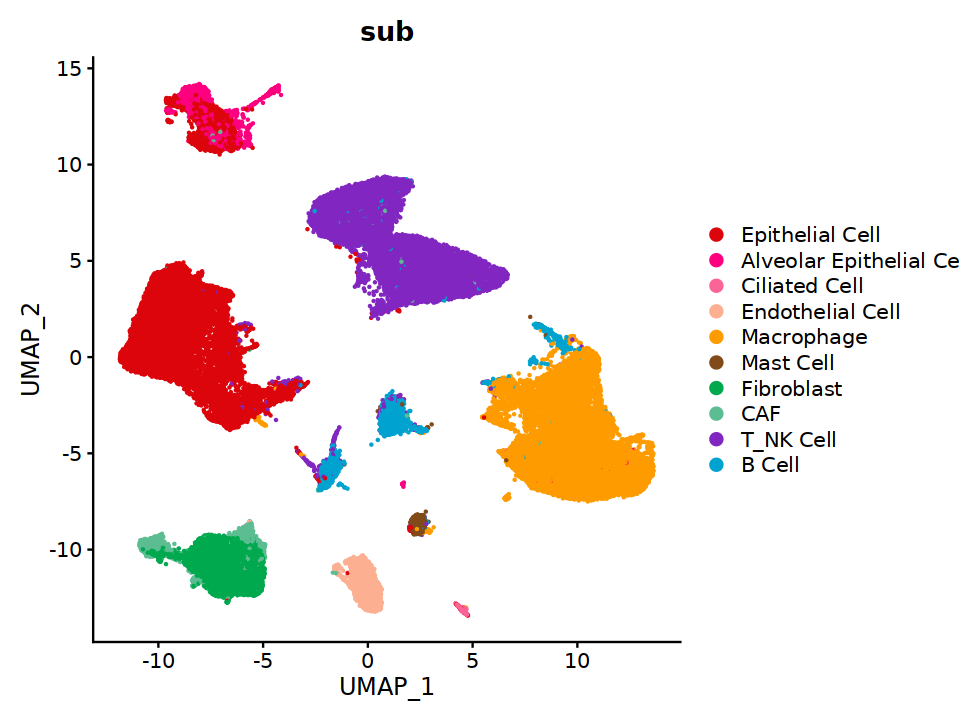

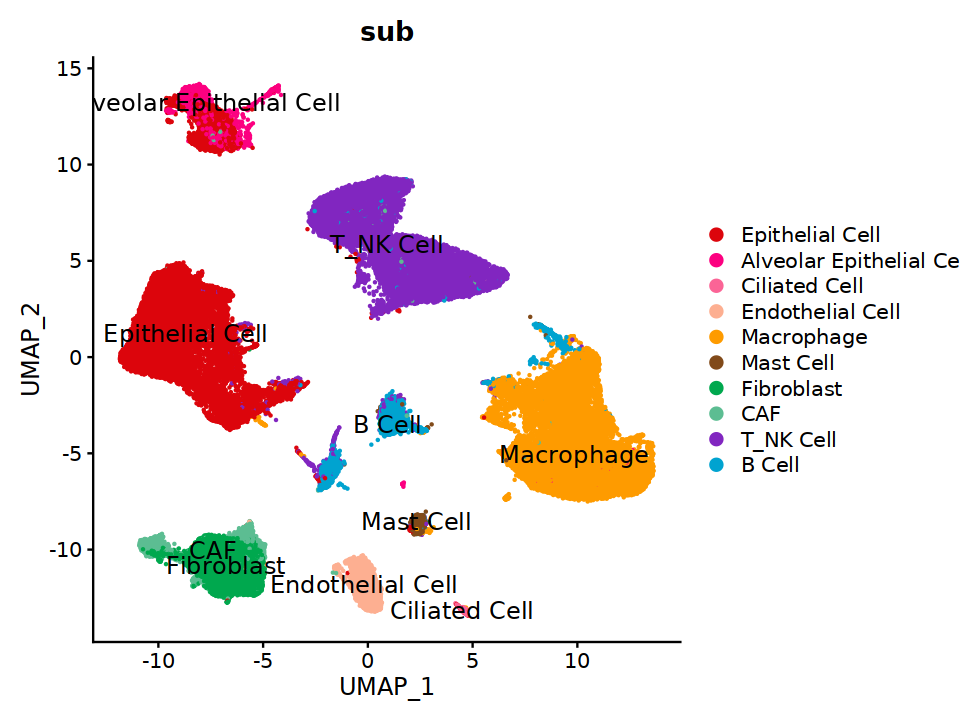

In [208]:
# sub
options(repr.plot.width=8,repr.plot.height=6)

group = 'sub'
obj$sub <- factor(obj$sub, levels = c('Epithelial Cell','Alveolar Epithelial Cell','Ciliated Cell','Endothelial Cell','Macrophage','Mast Cell','Fibroblast','CAF','T_NK Cell','B Cell'))

p <- DimPlot(obj, group.by = group, pt.size=0.2, label.size = 8, cols = cor_sub, raster=F) # label = T,
p
ggsave(paste0(group,"_umap.png"), bg='white',width=10, height=9, dpi = 300)
ggsave(paste0(group,"_umap.pdf"), bg='white',width=10, height=9, dpi = 300)

p <- DimPlot(obj, group.by = group, pt.size=0.2, label.size = 5, label = T, cols = cor_sub, raster=F) # 
p
ggsave(paste0(group,"_label_umap.png"), bg='white',width=10, height=8, dpi = 300)
ggsave(paste0(group,"_label_umap.pdf"), bg='white',width=10, height=8, dpi = 300)

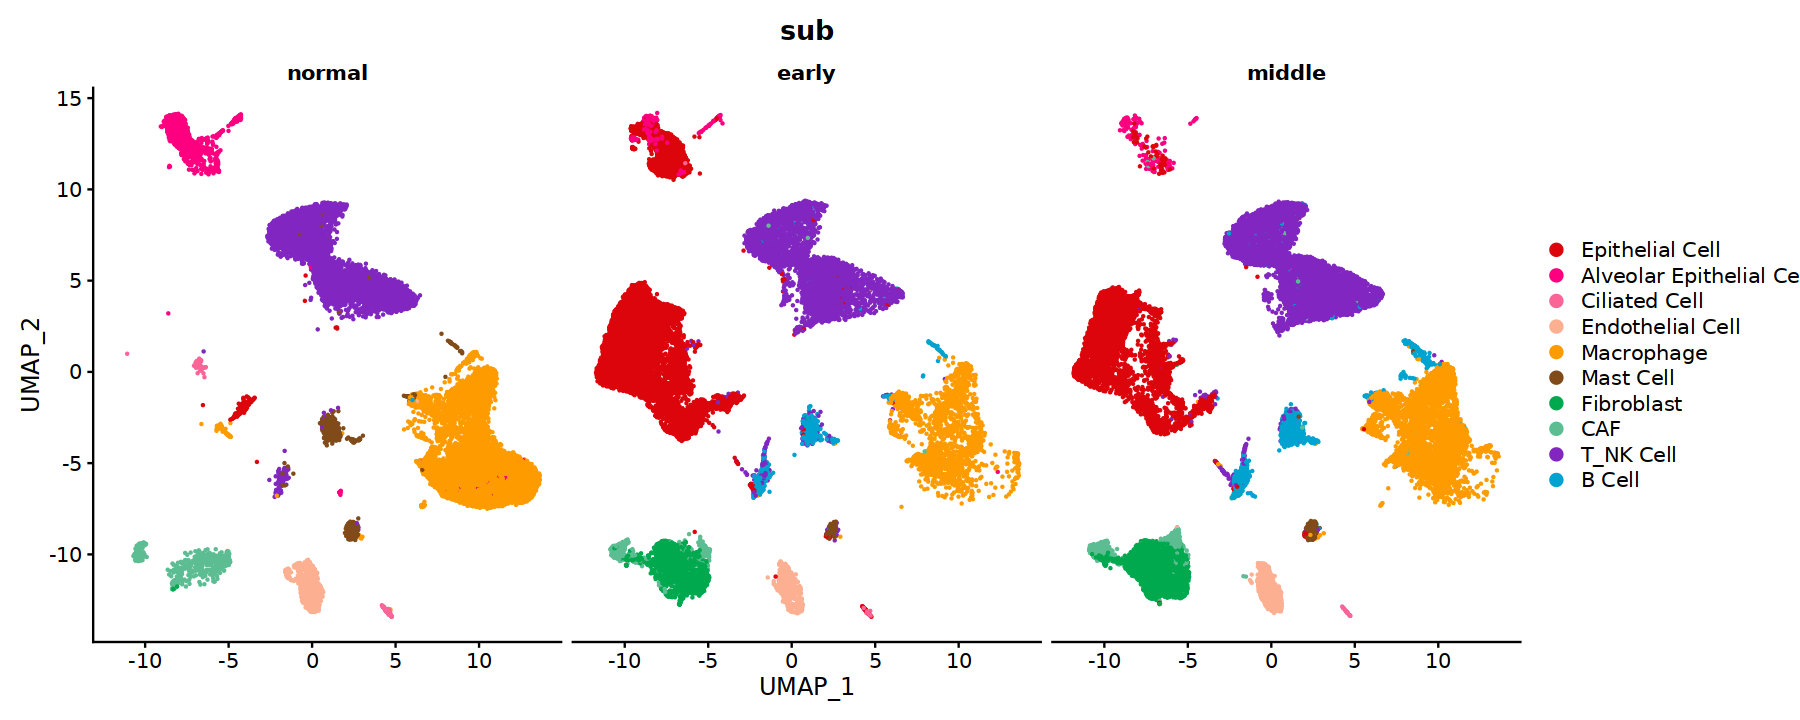

In [224]:
# sub split
options(repr.plot.width=15,repr.plot.height=6)

group = 'sub'
obj$sub <- factor(obj$sub, levels = c('Epithelial Cell','Alveolar Epithelial Cell','Ciliated Cell','Endothelial Cell','Macrophage','Mast Cell','Fibroblast','CAF','T_NK Cell','B Cell'))

p <- DimPlot(obj, group.by = group, split.by = 'stage',pt.size=0.2, label.size = 8, cols = cor_sub, raster=F) # label = T,
p
ggsave(paste0(group,"_split_umap.png"), bg='white',width=16, height=6, dpi = 300)
ggsave(paste0(group,"_split_umap.pdf"), bg='white',width=16, height=6, dpi = 300)

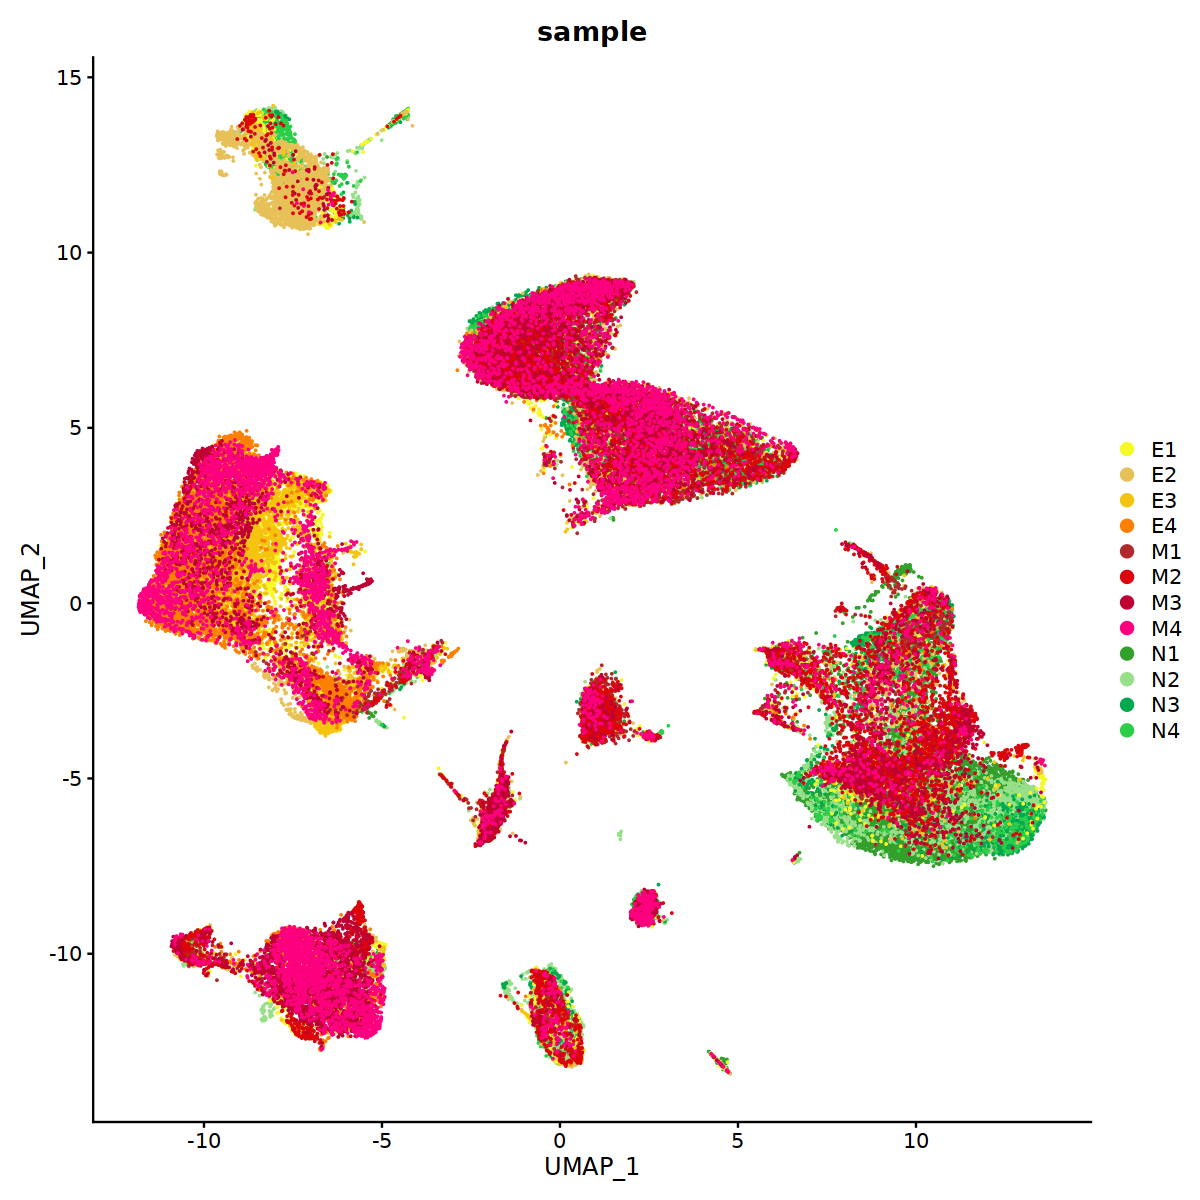

In [133]:
# sample
options(repr.plot.width=8,repr.plot.height=8)

p <- DimPlot(obj, group.by='sample', label.size = 8, cols = cor_sample, raster=F) #  pt.size=0.1,
p
ggsave(paste0("LUSC_sample.png"), bg='white',width=10, height=10, dpi = 300)
ggsave(paste0("LUSC_sample.pdf"), bg='white',width=10, height=10, dpi = 300)

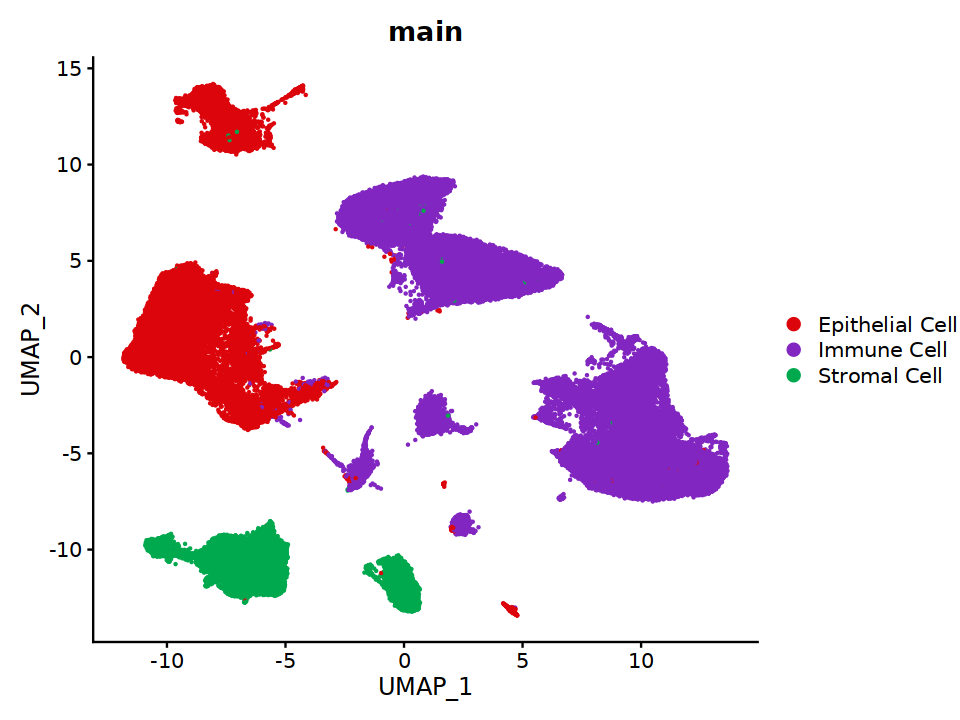

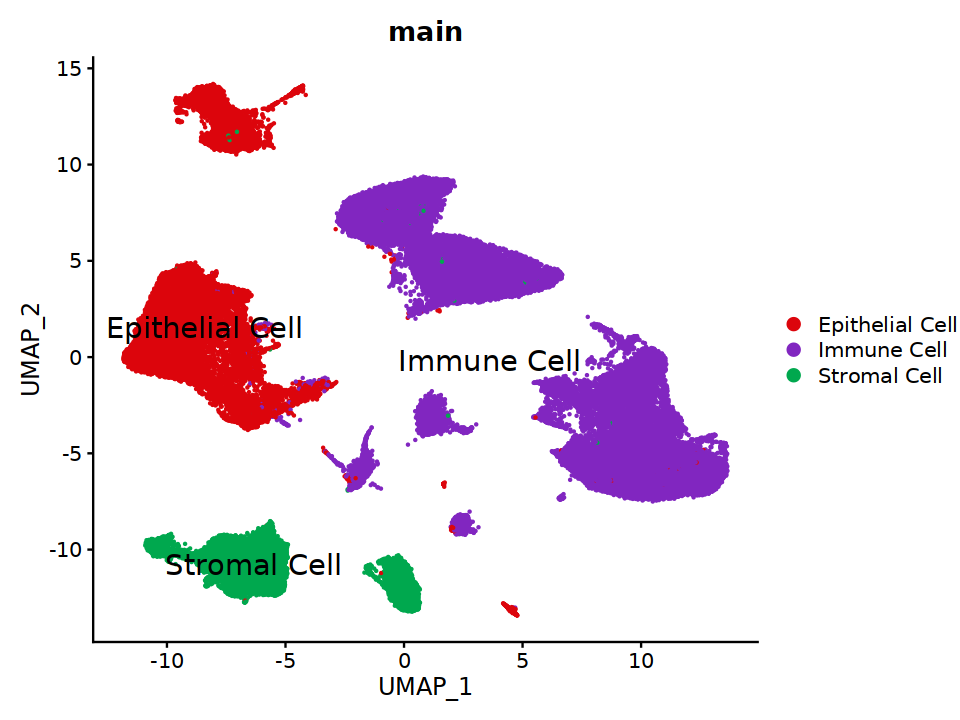

In [139]:
# main
options(repr.plot.width=8,repr.plot.height=6)

group = 'main'

p <- DimPlot(obj, group.by = group, pt.size=0.2, label.size = 8, cols = cor_main, raster=F) # label = T,
p
ggsave(paste0(group,"_umap.png"), bg='white',width=10, height=9, dpi = 300)
ggsave(paste0(group,"_umap.pdf"), bg='white',width=10, height=9, dpi = 300)

p <- DimPlot(obj, group.by = group, pt.size=0.2, label.size = 6, label = T, cols = cor_main, raster=F) # 
p
ggsave(paste0(group,"_label_umap.png"), bg='white',width=10, height=9, dpi = 300)
ggsave(paste0(group,"_label_umap.pdf"), bg='white',width=10, height=9, dpi = 300)

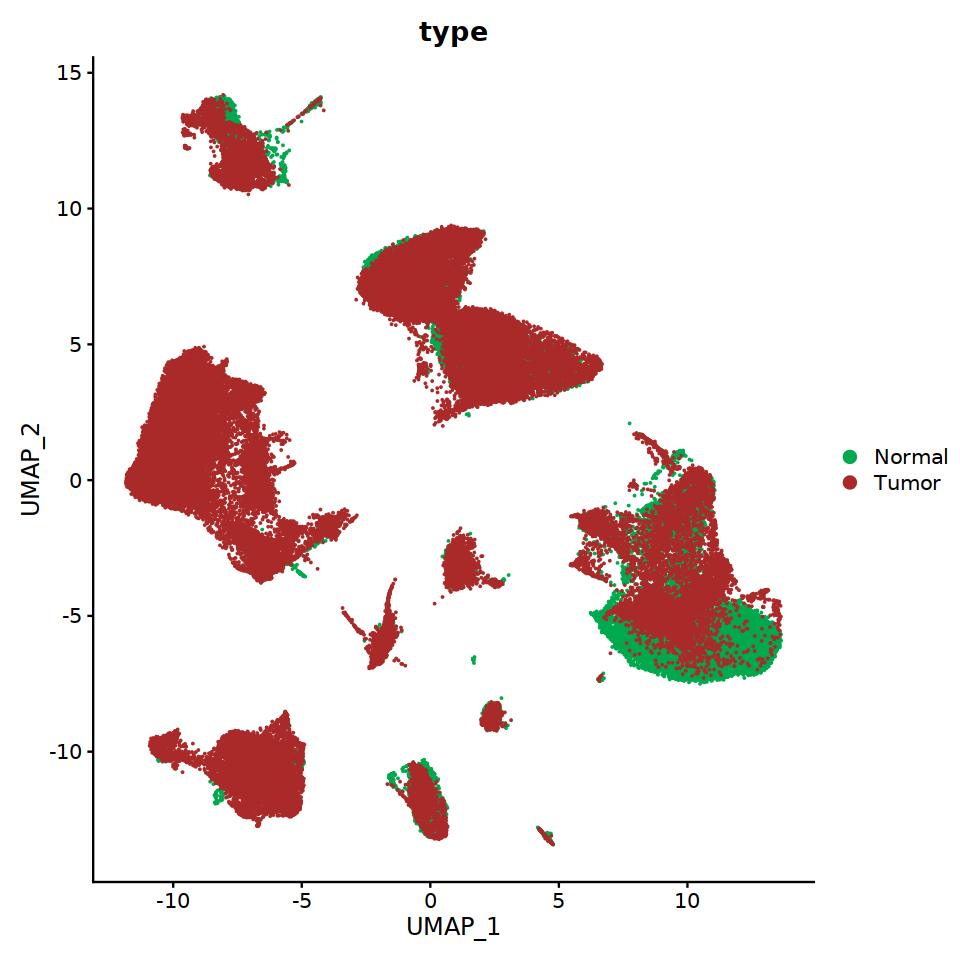

In [143]:
# type
options(repr.plot.width=8,repr.plot.height=8)

group = 'type'

p <- DimPlot(obj, group.by = group, label.size = 7, cols = cor_type, raster=F) # label = T, pt.size=0.2,
p
ggsave(paste0(group,"_umap.png"), bg='white',width=10, height=10, dpi = 300)
ggsave(paste0(group,"_umap.pdf"), bg='white',width=10, height=10, dpi = 300)

In [ ]:
# sub split
options(repr.plot.width=13,repr.plot.height=6)

group = 'sub'
obj$sub <- factor(obj$sub, levels = c('Epithelial Cell','Alveolar Epithelial Cell','Ciliated Cell','Endothelial Cell','Macrophage','Mast Cell','Fibroblast','CAF','T_NK Cell','B Cell'))

p <- DimPlot(obj, group.by = group, split.by = 'type',pt.size=0.2, label.size = 8, cols = cor_sub, raster=F) # label = T,
p
ggsave(paste0(group,"_split_type_umap.png"), bg='white',width=13, height=6, dpi = 300)
ggsave(paste0(group,"_split_type_umap.pdf"), bg='white',width=13, height=6, dpi = 300)

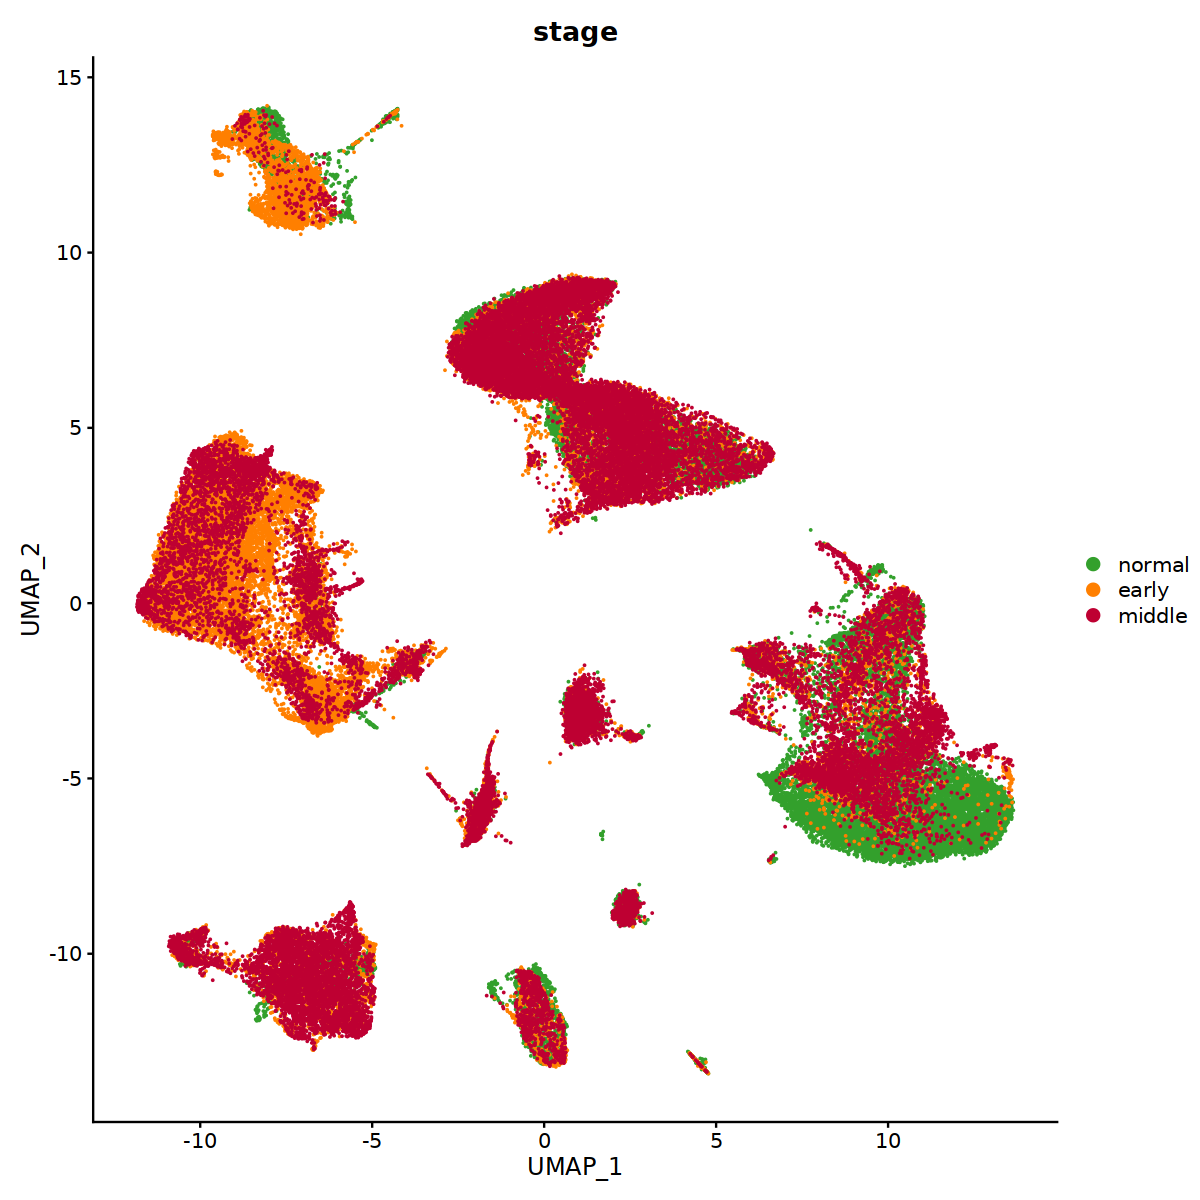

In [145]:
# stage
options(repr.plot.width=10,repr.plot.height=10)

group = 'stage'

p <- DimPlot(obj, group.by = group, label.size = 7, cols = cor_stage, raster=F) # label = T, pt.size=0.2,
p
ggsave(paste0(group,"_umap.png"), bg='white',width=10, height=10, dpi = 300)
ggsave(paste0(group,"_umap.pdf"), bg='white',width=10, height=10, dpi = 300)

### 2.2 dotplot

In [146]:
obj$subcelltype <- obj$sub
obj$subcelltype <- factor(obj$subcelltype, levels = c('Macrophage','Ciliated Cell','Mast Cell','Alveolar Epithelial Cell','Endothelial Cell',
                                                      'T_NK Cell','B Cell','Epithelial Cell','CAF','Fibroblast'))
setwd('/data/work/02.result/others/Chen/proj_lusc/zbl/02.result/end_plot/LUSC/fig')

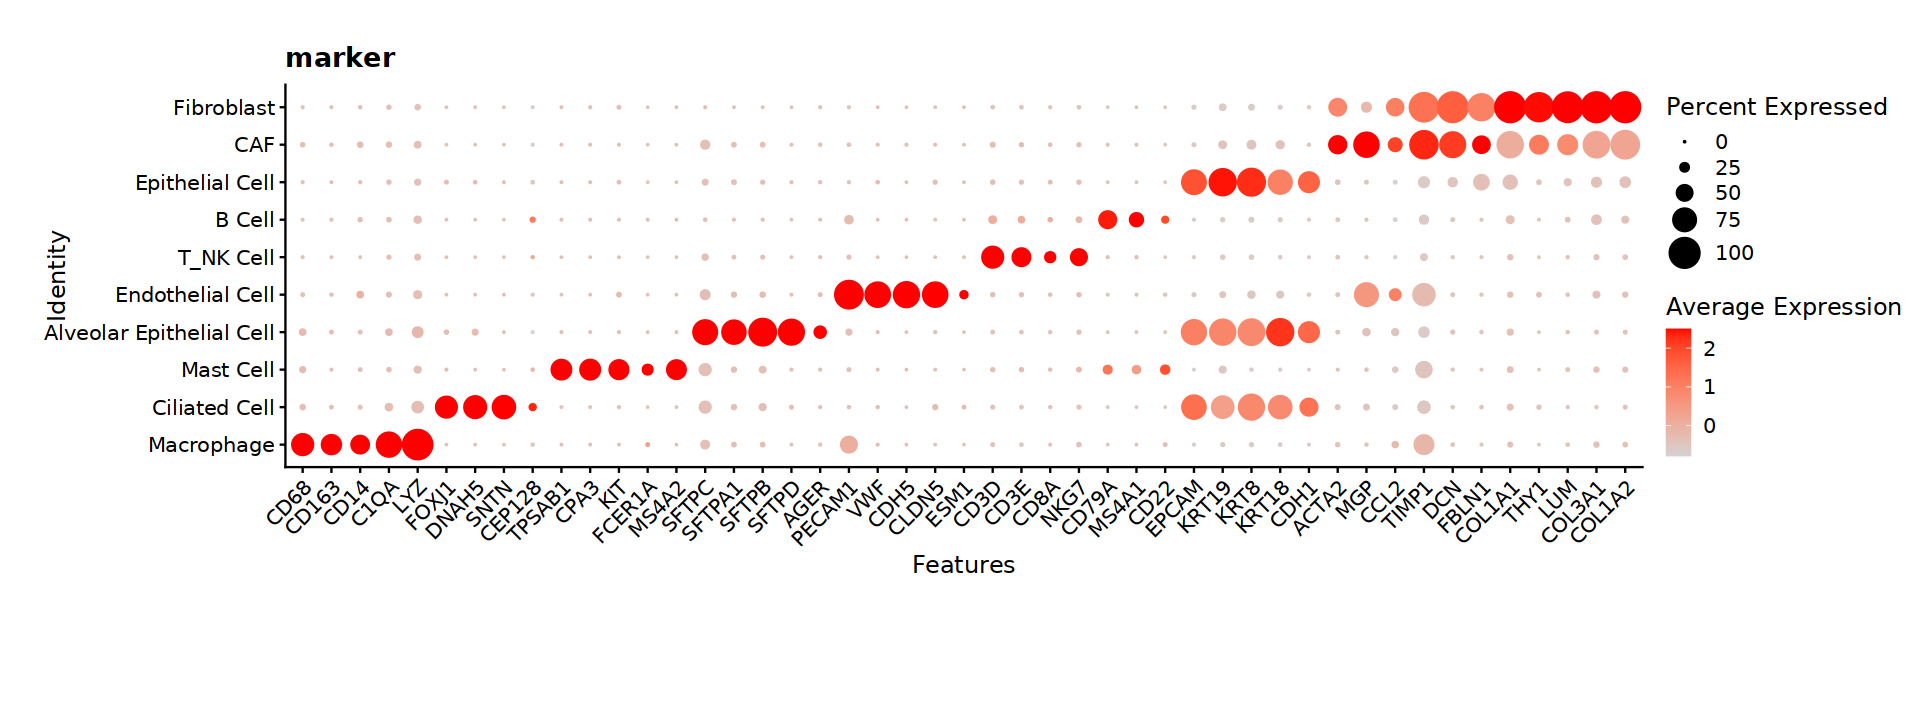

In [147]:
options(repr.plot.width=16, repr.plot.height=6)

marker_genes <-  c(
  "CD68", "CD163", "CD14", "C1QA", "LYZ", # Macrophage (MΦ)
  "FOXJ1", "DNAH5", "SNTN", "CEP128", # Ciliated Epithelial Cell
  "TPSAB1", "CPA3", "KIT", "FCER1A", "MS4A2", # Mast Cell
  "SFTPC", "SFTPA1", "SFTPB", "SFTPD", "AGER", # Alveolar Epithelial Cell
  "PECAM1", "VWF", "CDH5", "CLDN5", "ESM1", # Endothelial Cell
  "CD3D", "CD3E", "CD8A", "NKG7", # T_NK Cell 
  "CD79A", "MS4A1", "CD20", "CD22", # B Cell 
  "EPCAM", "KRT19", "KRT8", "KRT18", "CDH1", # Epithelial Cell
  "ACTA2", "MGP",'CCL2','TIMP1',"DCN",'TAGLN1',"FBLN1","COL1A1", "THY1", # CAF
  "LUM", "COL3A1", "COL1A2"  # Fibroblast
)

p3 <- DotPlot(obj, cols = c("lightgrey", "red"),  features = marker_genes, group.by = 'subcelltype', dot.scale = 8, cluster.idents = FALSE) + 
              theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1, size = 12),plot.margin = margin(1, 1, 3, 1, "cm")) +
              labs(title = "marker")
                   # x = "markers",
                   # y = "Seurat Clusters)

print(p3)
ggsave(paste0("Dotplot_cluster_sub.png"), bg='white', width=16,height=6, dpi = 300)
ggsave(paste0("Dotplot_cluster_sub.pdf"), bg='white', width=16,height=6, dpi = 300)

### 2.3 featureplot

In [86]:
marker_genes <-  c(
  "CD68", "CD163", "CD14", "C1QA", "LYZ", # Macrophage (MΦ)
  "FOXJ1", "DNAH5", "SNTN", "CEP128", # Ciliated Epithelial Cell
  "TPSAB1", "CPA3", "KIT", "FCER1A", "MS4A2", # Mast Cell
  "SFTPC", "SFTPA1", "SFTPB", "SFTPD", "AGER", # Alveolar Epithelial Cell
  "PECAM1", "VWF", "CDH5", "CLDN5", "ESM1", # Endothelial Cell
  "CD3D", "CD3E", "CD8A", "NKG7", # T_NK Cell 
  "CD79A", "MS4A1", "CD22", # B Cell 
  "EPCAM", "KRT19", "KRT8", "KRT18", "CDH1", # Epithelial Cell
  "ACTA2", "MGP",'CCL2','TIMP1',"DCN","FBLN1","COL1A1", "THY1", # CAF
  "LUM", "COL3A1", "COL1A2"  # Fibroblast
)

# 提取Seurat对象中实际存在的基因
marker_genes <- intersect(marker_genes, rownames(obj@assays$RNA@data))

# 生成缺失基因报告 ---------------------------------------------------------
missing_genes <- setdiff(marker_genes, existing_genes)
if (length(missing_genes) > 0) {
  message("\n以下基因在数据中缺失，将被跳过：\n", paste(missing_genes, collapse = ", "))
}

In [91]:
# 设置PDF设备参数
pdf("./featureplot/all_markers.pdf", width = 10, height = 10)
    
    for (gene in marker_genes) { # 循环绘制每个基因的FeaturePlot并写入PDF
      p <- FeaturePlot(obj, features = gene, cols = viridis(50, option = "D"), raster = FALSE) +  labs(title = gene)
      print(p)  # 关键：必须用print()输出到设备
    }
dev.off()  

# 单独保存每个基因的PNG
for (gene in marker_genes) {
  p <- FeaturePlot(obj, features = gene, cols = viridis(50, option = "D"), raster = FALSE) +  labs(title = gene)
  ggsave(paste0("./featureplot/", gene, ".png"), plot = p, width = 8, height = 8,  bg='white', dpi = 300)
}

pdf 
  2

In [12]:
# 单独保存每个基因的PNG

p <- FeaturePlot(obj, features = 'CTSC', cols = viridis(50, option = "D"), raster = FALSE) +  labs(title = 'CTSC')
ggsave(paste0("./fig/featureplot/CTSC.png"), plot = p, width = 8, height = 8,  bg='white', dpi = 300)


In [10]:
getwd()

[1] "/data/work/02.result/others/Chen/proj_lusc/zbl/02.result/end_plot/LUSC"

### 2.4 celltype percent（Sankey_bar）

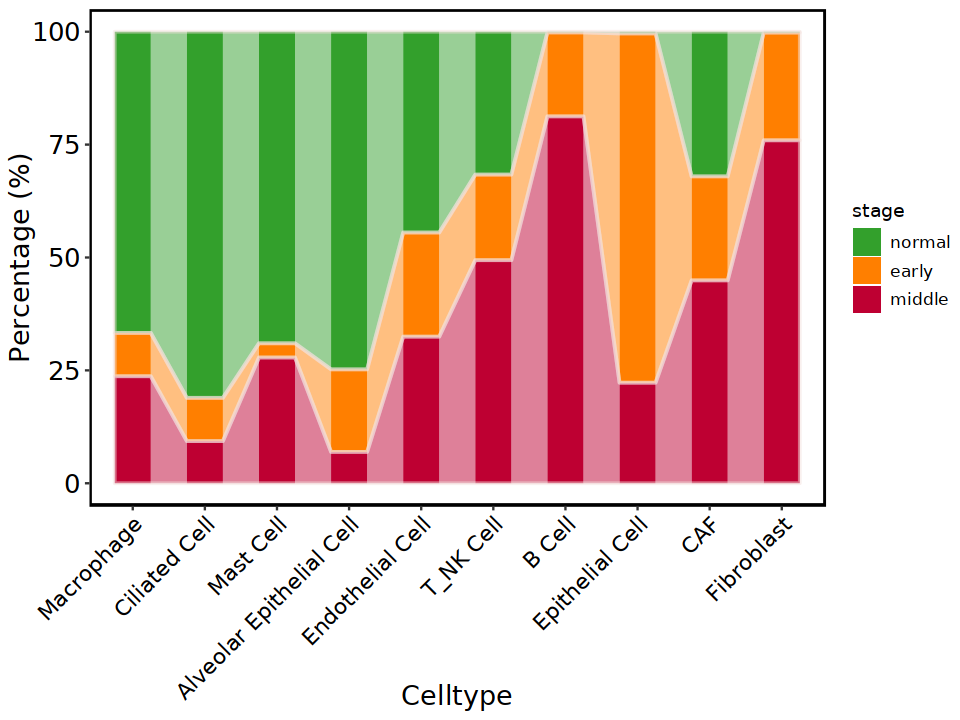

In [148]:
options(repr.plot.width=8, repr.plot.height=6)

# 绘制stage在细胞亚型中的流动分布
Sankey_bar(obj, 
             x_var = "sub",
             y_var = "stage",
             color_palette = cor_stage,
             output_prefix = "percent_stage_sub", width = 8, height = 6)

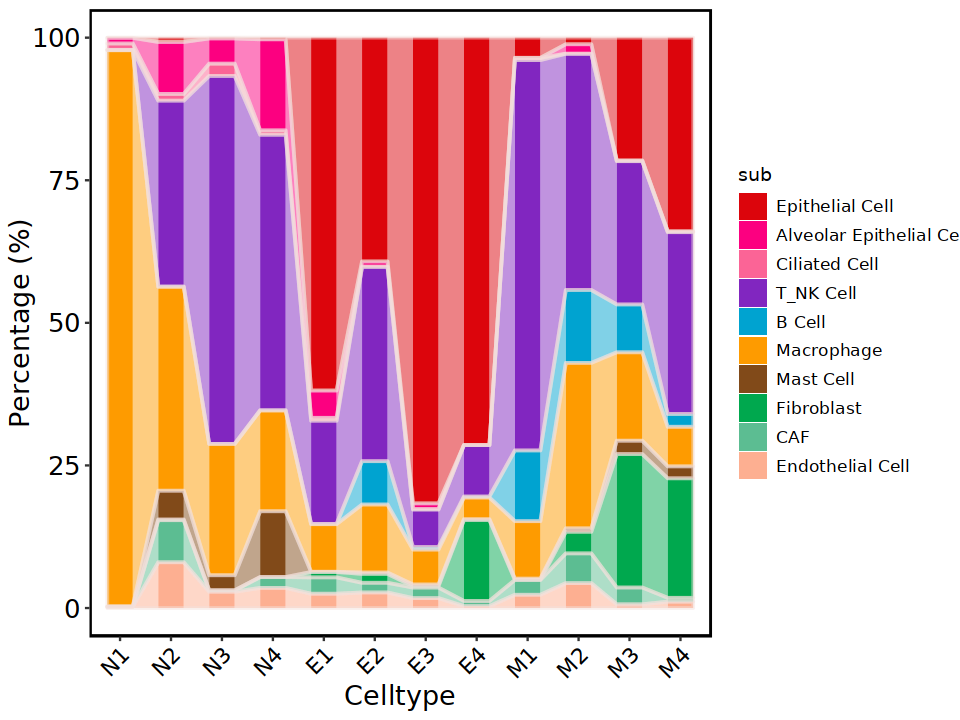

In [227]:
options(repr.plot.width=8, repr.plot.height=6)

# 绘制stage在细胞亚型中的流动分布
Sankey_bar(obj, 
             x_var = "sample",
             y_var = "sub",
             color_palette = cor_sub,
             output_prefix = "percent_sample_sub", width = 10, height = 6)

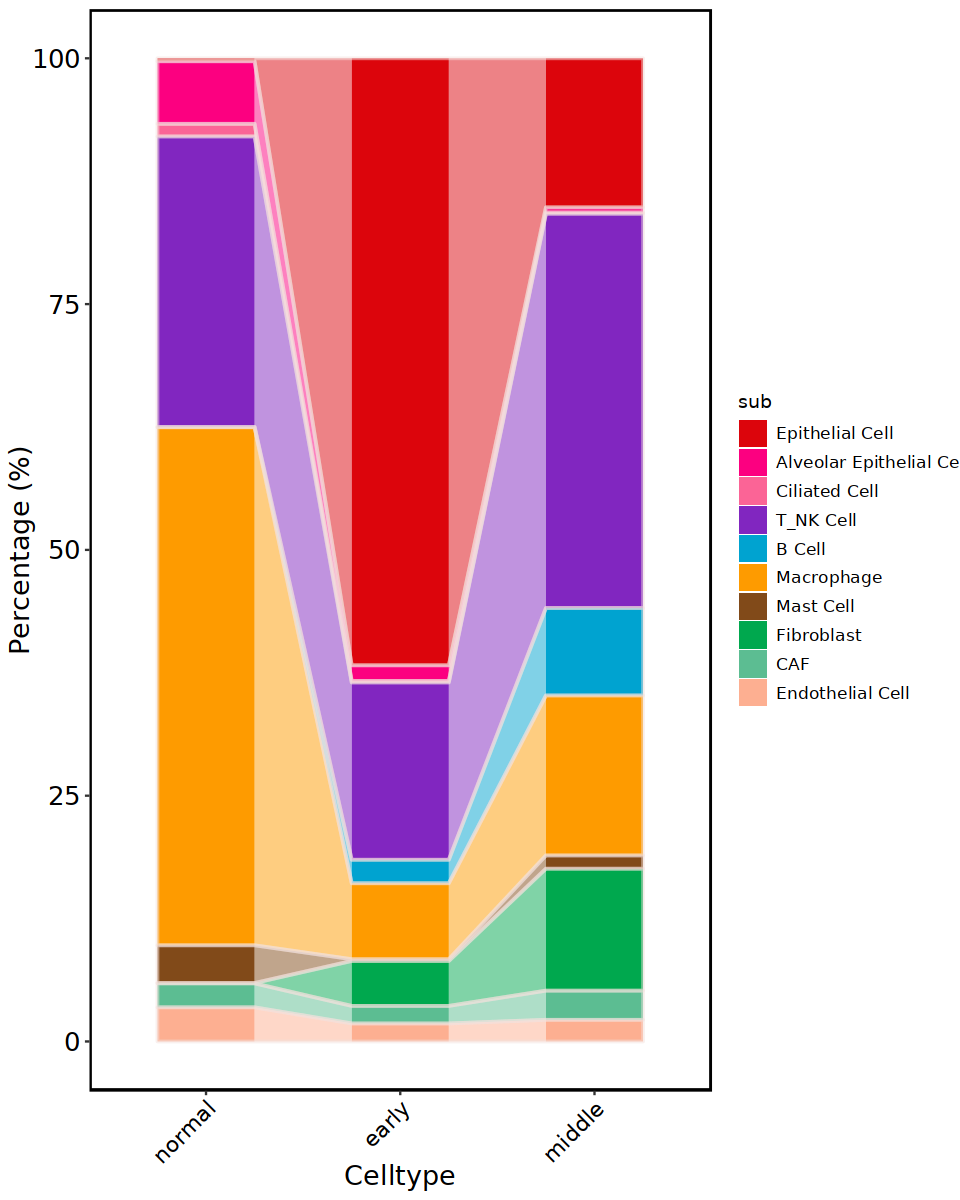

In [209]:
options(repr.plot.width=8, repr.plot.height=10)

Sankey_bar(obj, 
             x_var = "stage",
             y_var = "sub",
             color_palette = cor_sub,
             output_prefix = "percent_sub_stage", width = 8, height = 10)

In [ ]:
options(repr.plot.width=8, repr.plot.height=10)

Sankey_bar(obj, 
             x_var = "stage",
             y_var = "sub",
             color_palette = cor_sub,
             output_prefix = "percent_sub_stage", width = 8, height = 10)

In [217]:
table(obj$type,obj$stage)

        
         normal early middle
  Normal  25697     0      0
  Tumor       0 25215  29568

In [ ]:
options(repr.plot.width=6, repr.plot.height=8)

Sankey_bar(obj, 
             x_var = "type",
             y_var = "sub",
             color_palette = cor_sub,
             output_prefix = "percent_sub_type", width = 8, height = 10)

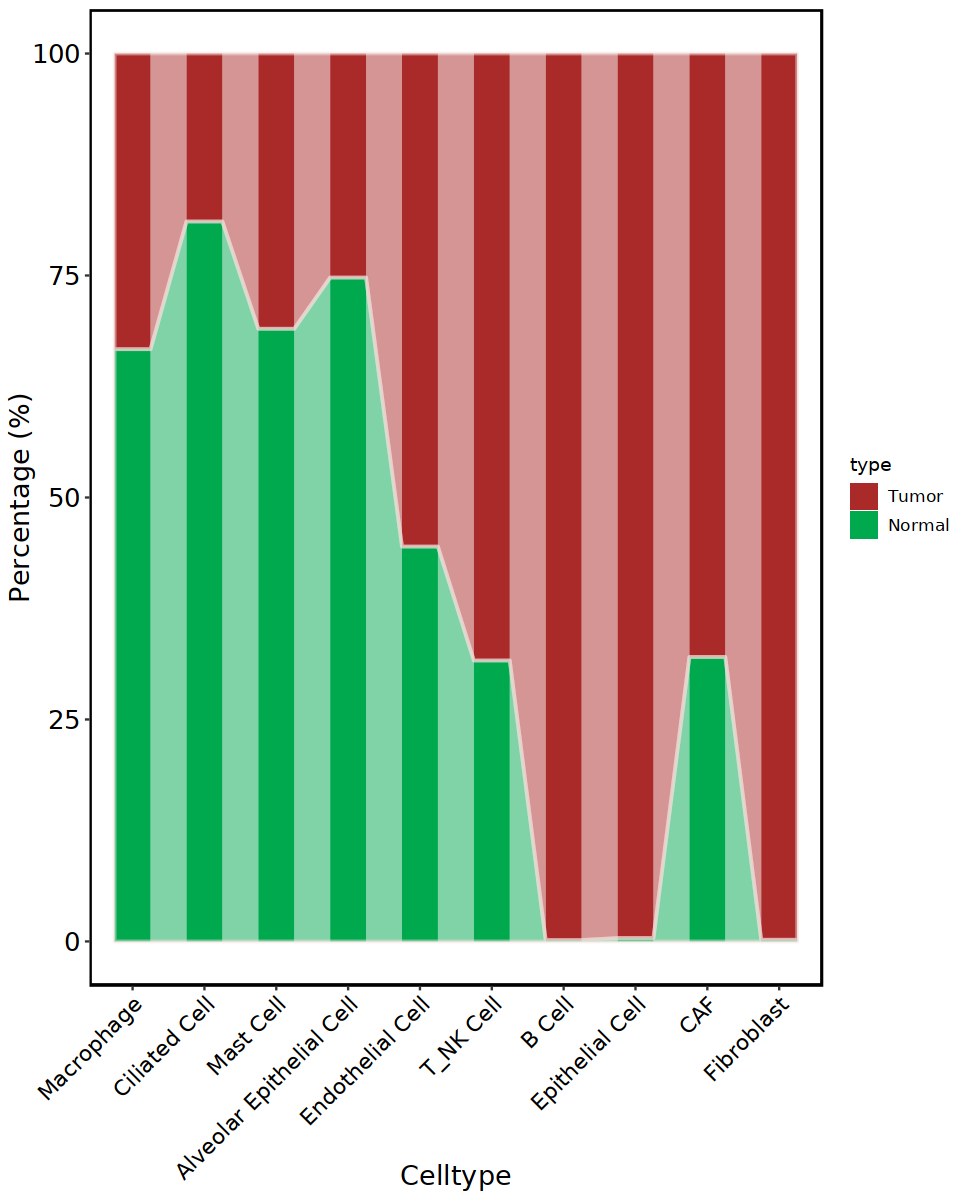

In [220]:
options(repr.plot.width=6, repr.plot.height=8)

Sankey_bar(obj, 
             x_var = "sub",
             y_var = "type",
             color_palette = cor_type,
             output_prefix = "percent_type_sub", width = 8, height = 10)

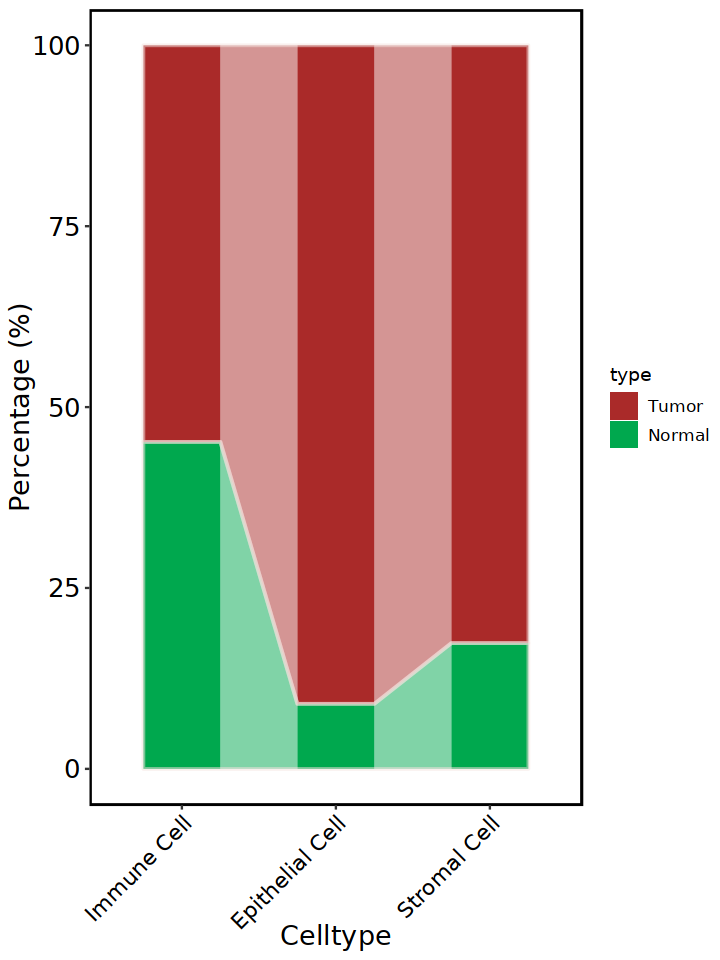

In [221]:
options(repr.plot.width=6, repr.plot.height=8)

Sankey_bar(obj, 
             x_var = "main",
             y_var = "type",
             color_palette = cor_type,
             output_prefix = "percent_type_main", width = 8, height = 10)

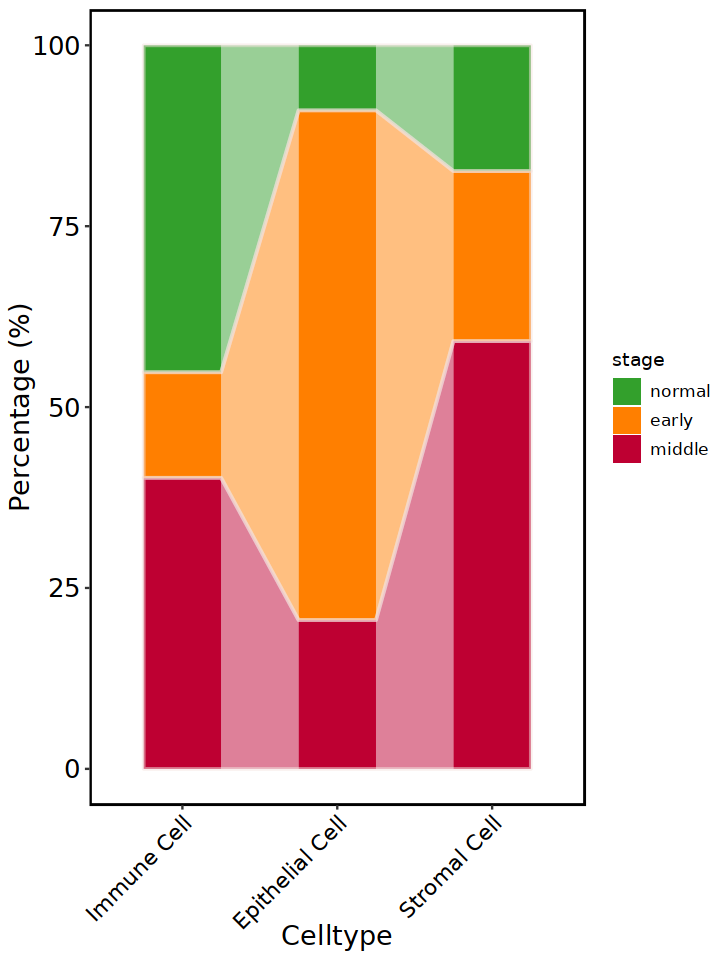

In [222]:
options(repr.plot.width=6, repr.plot.height=8)

Sankey_bar(obj, 
             x_var = "main",
             y_var = "stage",
             color_palette = cor_stage,
             output_prefix = "percent_stage_main", width = 8, height = 10)

#### line_percent

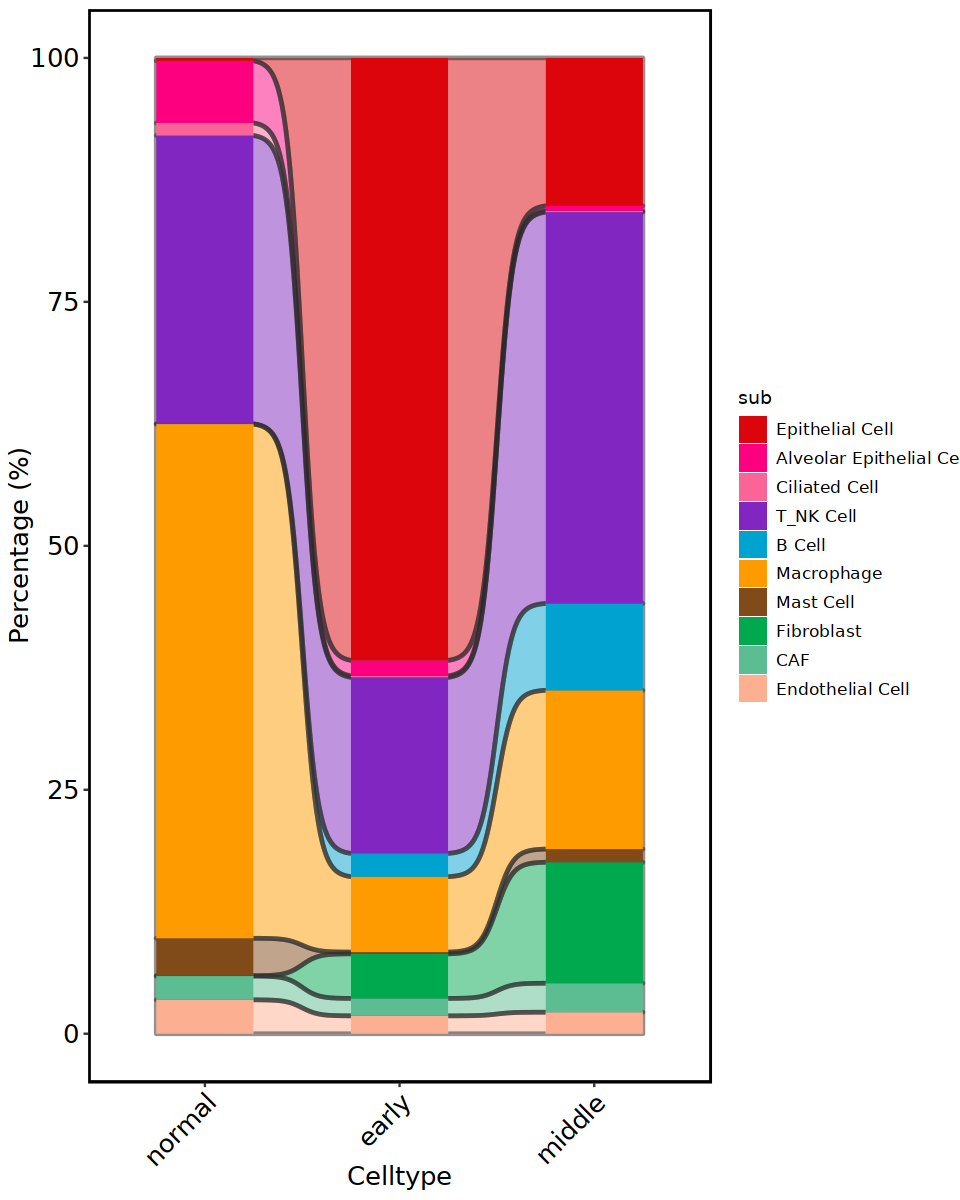

In [211]:
x_var = "stage"
y_var = "sub"
color_palette = cor_sub
output_prefix = "line_percent_sub_stage"
width = 8
height = 10

filtered_data <- obj@meta.data %>% dplyr::filter(!is.na(.data[[x_var]]), !is.na(.data[[y_var]])) 
# 核心比例计算逻辑（保持原有结构）
percentage <- as.data.frame(table(filtered_data[[x_var]], filtered_data[[y_var]])) %>% setNames(c(x_var, y_var, "count")) %>%
group_by(.data[[x_var]]) %>%  mutate(total = sum(count), percentage = count / total * 100)

# 因子化处理
percentage[[x_var]] <- factor(percentage[[x_var]], levels = unique(filtered_data[[x_var]]))
percentage[[y_var]] <- factor(percentage[[y_var]], levels = names(color_palette))

# 可视化层（保持流式图核心元素）
p <- ggplot(percentage,  aes(x = .data[[x_var]], y = percentage, stratum = .data[[y_var]],  alluvium = .data[[y_var]], fill = .data[[y_var]])) +

#geom_flow(width = 0.5, curve_type = "sigmoid", alpha = 0.5) +
geom_alluvium(width = 0.5, curve_type = "sigmoid", color = "#222222", fill = 'NA', size = 1) +
geom_stratum(width = 0.5, alpha = 1, color = NA) +
scale_fill_manual(values = color_palette) +
labs(x = "Celltype", y = "Percentage (%)", fill = y_var) +
theme(
  panel.grid = element_blank(),
  panel.background = element_blank(),
  plot.background = element_rect(fill = "white"),
  panel.border = element_rect(fill = NA, color = "black", size = 1),
  axis.text.x = element_text(angle = 45, hjust = 1, color = "black", size = 15),
  axis.text.y = element_text(color = "black", size = 15),
  axis.title = element_text(size = 15),
  legend.text = element_text(size = 10)
)

p

# ggsave(paste0(output_prefix, ".png"), p, width = width, height = height, bg='white', dpi = 300)
# ggsave(paste0(output_prefix, ".pdf"), p, width = width, height = height)

In [198]:
table(obj$sub,obj$stage)

                          
                           normal early middle
  Epithelial Cell              77 15567   4483
  Alveolar Epithelial Cell   1636   400    152
  Ciliated Cell               330    39     38
  Endothelial Cell            893   463    652
  Macrophage                13541  1949   4811
  Mast Cell                   986    45    398
  Fibroblast                    9  1152   3667
  CAF                         626   450    878
  T_NK Cell                  7594  4548  11858
  B Cell                        5   602   2631

### 2.5 CLEC2B violin

In [6]:
library(Seurat)
library(ggplot2)
library(ggpubr)

# 假设obj_sub是您的Seurat对象
# 首先提取CLEC2B的表达数据
plot_data <- FetchData(obj, vars = c("CLEC2B", "stage"))
head(plot_data)

,CTSC,stage
,<dbl>,<fct>
p018_AAACCCACAACTTGGT-1,0.000000,normal
p018_AAACCCACAAGAATAC-1,2.562001,normal
p018_AAACCCACATCCGGCA-1,0.000000,normal
p018_AAACCCACATGATCTG-1,1.754028,normal
p018_AAACCCAGTAGTCGTT-1,2.419537,normal
p018_AAACCCATCAAGTCGT-1,0.000000,normal


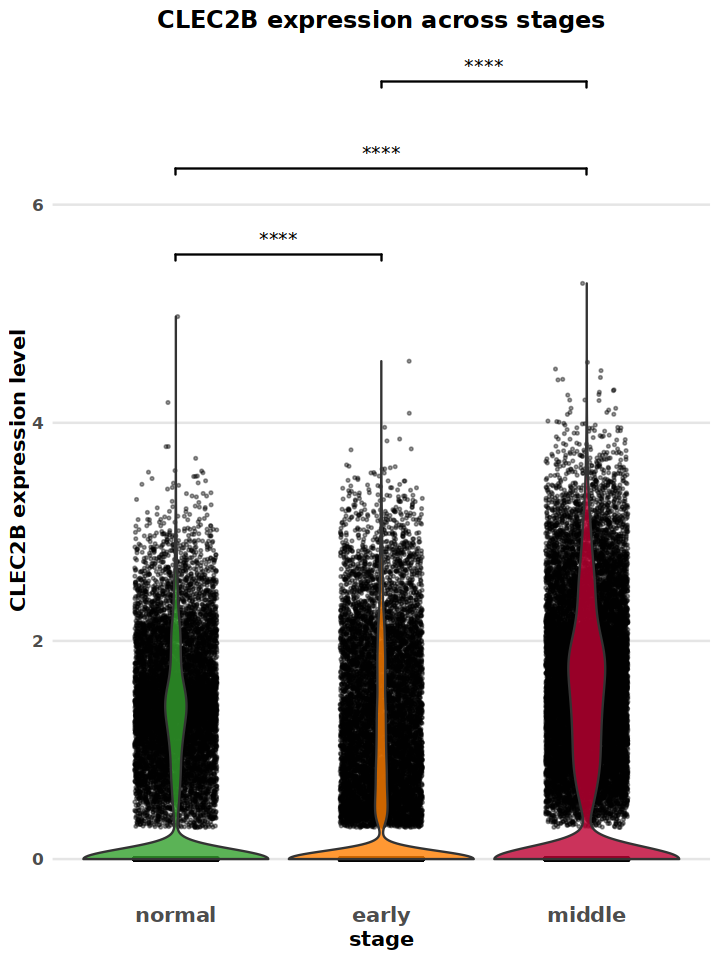

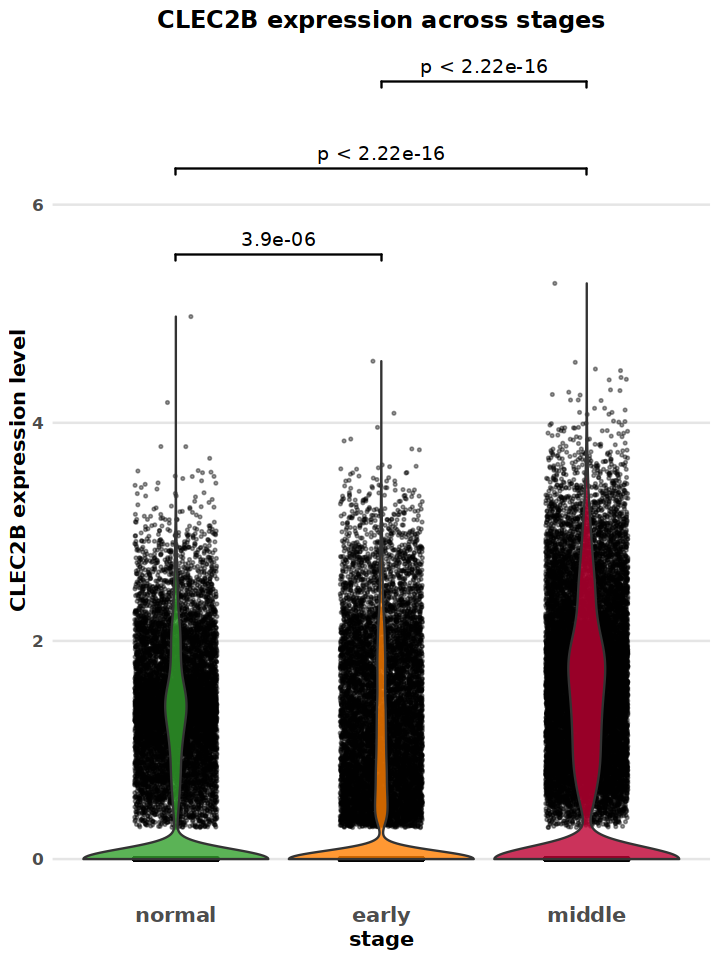

In [229]:
options(repr.plot.width=6,repr.plot.height=8)


# 定义美观的颜色方案
# stage_colors <- c("normal" = "#4DAF4A",  # 好看的绿色
#                  "early" = "#377EB8",   # 蓝色
#                  "middle" = "#E41A1C") # 红色

cor_stage <- c(
  "normal" = "#33A02C", # N系列 - 绿色系
  "early" = "#FF7F00", # E系列 - 黄色系
  "middle" = "#BE0032" # M系列 - 红色系
)

# 基础绘图
p <- ggplot(plot_data, aes(x = stage, y = CLEC2B, fill = stage)) +
        
        geom_jitter(width = 0.2, alpha = 0.4, size = 0.4, color = "black") +  # 散点(jitter避免重叠)
        geom_violin(scale = "width", trim = TRUE, alpha = 0.8) +  # 半透明小提琴图
        scale_fill_manual(values = cor_stage) +  # 应用自定义颜色
        scale_x_discrete(limits = c("normal", "early", "middle")) + # 确保顺序正确
              labs(
                y = "CLEC2B expression level",
                x = "stage",
                title = "CLEC2B expression across stages"
              ) +
                  theme_minimal(base_size = 12) +
                  theme(
                    legend.position = "none",
                    plot.title = element_text(hjust = 0.5, face = "bold", size = 14),
                    axis.title = element_text(face = "bold", size = 12),  # 坐标轴标题加粗
                    axis.text = element_text(face = "bold", size = 10),  # 坐标轴文本(包括分组标签)加粗
                    axis.text.x = element_text(face = "bold", size = 12), # 特别指定X轴文本加粗
                    panel.grid.major.y = element_line(color = "grey90"),
                    panel.grid.minor.y = element_blank(),
                    panel.grid.major.x = element_blank()
                  )

# 添加统计检验
p1 <- p + stat_compare_means(
  comparisons = list(
    c("normal", "early"),
    c("normal", "middle"),
    c("early", "middle")
  ),
  method = "wilcox.test", # 使用Wilcoxon秩和检验
  label = "p.signif", # 显示显著性标记
  tip.length = 0.01,
  size = 4,
  bracket.size = 0.5,
  step.increase = 0.15
)



p1
# 保存图片
ggsave("CLEC2B_expression_violin_signif_2.png", plot = p1, bg='white', width = 6, height = 8, dpi = 300)
ggsave("CLEC2B_expression_violin_signif_2.pdf", plot = p1, width = 6, height = 8, dpi = 300)

# 添加统计检验
p2 <- p + stat_compare_means(
  comparisons = list(
    c("normal", "early"),
    c("normal", "middle"),
    c("early", "middle")
  ),
  method = "wilcox.test", # 使用 Wilcoxon 秩和检验
  label = "p = {p.adj}", # 显示 p 值
  tip.length = 0.01,
  size = 4,
  bracket.size = 0.5,
  step.increase = 0.15
)


p2
# 保存图片
ggsave("CLEC2B_expression_violin_num_2.png", plot = p2, bg='white', width = 6, height = 8, dpi = 300)
ggsave("CLEC2B_expression_violin_num_2.pdf", plot = p2, width = 6, height = 8, dpi = 300)

## orthers

,CTSC,stage
,<dbl>,<fct>
p018_AAACCCACAACTTGGT-1,0.000000,normal
p018_AAACCCACAAGAATAC-1,2.562001,normal
p018_AAACCCACATCCGGCA-1,0.000000,normal
p018_AAACCCACATGATCTG-1,1.754028,normal
p018_AAACCCAGTAGTCGTT-1,2.419537,normal
p018_AAACCCATCAAGTCGT-1,0.000000,normal


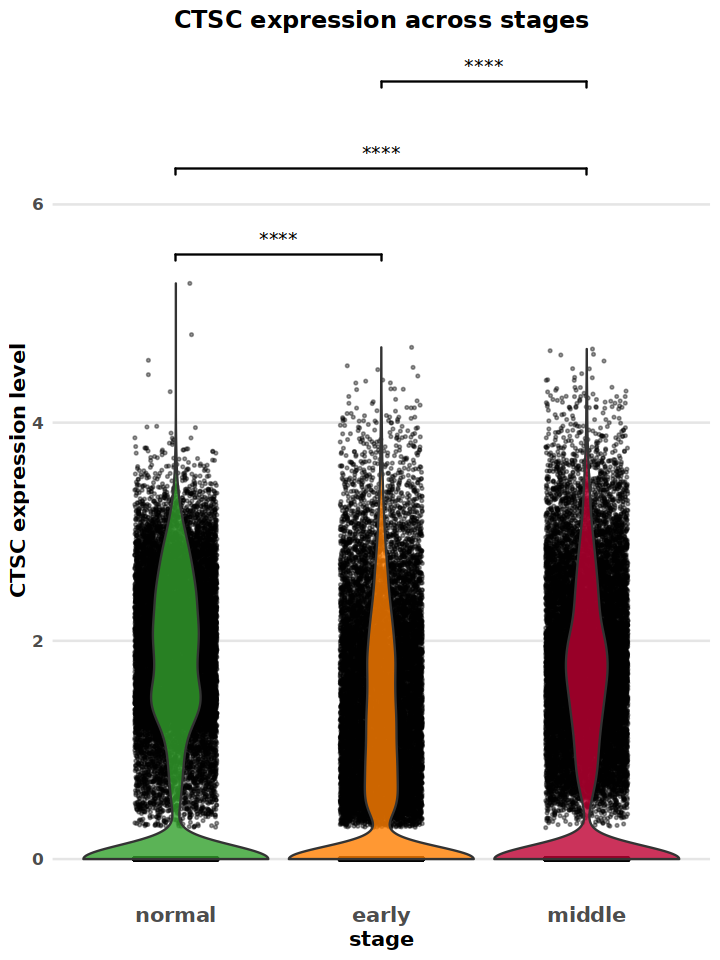

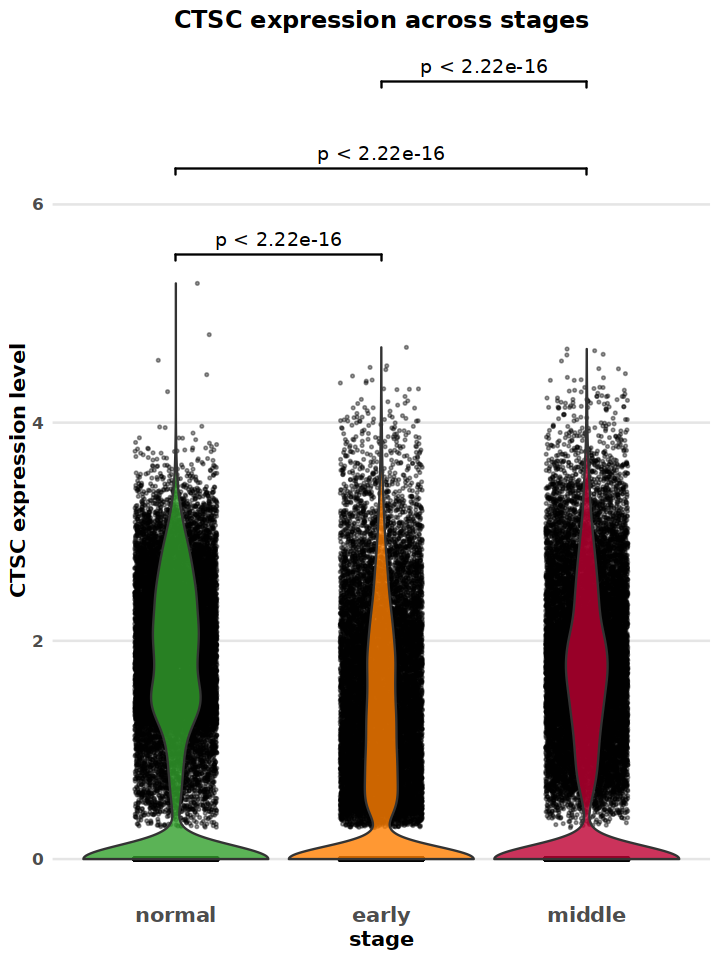

In [9]:
library(Seurat)
library(ggplot2)
library(ggpubr)

# 假设obj_sub是您的Seurat对象
# 首先提取CLEC2B的表达数据
plot_data <- FetchData(obj, vars = c("CTSC", "stage"))
head(plot_data)
options(repr.plot.width=6,repr.plot.height=8)


# 定义美观的颜色方案
# stage_colors <- c("normal" = "#4DAF4A",  # 好看的绿色
#                  "early" = "#377EB8",   # 蓝色
#                  "middle" = "#E41A1C") # 红色

cor_stage <- c(
  "normal" = "#33A02C", # N系列 - 绿色系
  "early" = "#FF7F00", # E系列 - 黄色系
  "middle" = "#BE0032" # M系列 - 红色系
)

# 基础绘图
p <- ggplot(plot_data, aes(x = stage, y = CTSC, fill = stage)) +
        
        geom_jitter(width = 0.2, alpha = 0.4, size = 0.4, color = "black") +  # 散点(jitter避免重叠)
        geom_violin(scale = "width", trim = TRUE, alpha = 0.8) +  # 半透明小提琴图
        scale_fill_manual(values = cor_stage) +  # 应用自定义颜色
        scale_x_discrete(limits = c("normal", "early", "middle")) + # 确保顺序正确
              labs(
                y = "CTSC expression level",
                x = "stage",
                title = "CTSC expression across stages"
              ) +
                  theme_minimal(base_size = 12) +
                  theme(
                    legend.position = "none",
                    plot.title = element_text(hjust = 0.5, face = "bold", size = 14),
                    axis.title = element_text(face = "bold", size = 12),  # 坐标轴标题加粗
                    axis.text = element_text(face = "bold", size = 10),  # 坐标轴文本(包括分组标签)加粗
                    axis.text.x = element_text(face = "bold", size = 12), # 特别指定X轴文本加粗
                    panel.grid.major.y = element_line(color = "grey90"),
                    panel.grid.minor.y = element_blank(),
                    panel.grid.major.x = element_blank()
                  )

# 添加统计检验
p1 <- p + stat_compare_means(
  comparisons = list(
    c("normal", "early"),
    c("normal", "middle"),
    c("early", "middle")
  ),
  method = "wilcox.test", # 使用Wilcoxon秩和检验
  label = "p.signif", # 显示显著性标记
  tip.length = 0.01,
  size = 4,
  bracket.size = 0.5,
  step.increase = 0.15
)



p1
# 保存图片
ggsave("CTSC_expression_violin_signif_2.png", plot = p1, bg='white', width = 6, height = 8, dpi = 300)
ggsave("CTSC_expression_violin_signif_2.pdf", plot = p1, width = 6, height = 8, dpi = 300)

# 添加统计检验
p2 <- p + stat_compare_means(
  comparisons = list(
    c("normal", "early"),
    c("normal", "middle"),
    c("early", "middle")
  ),
  method = "wilcox.test", # 使用 Wilcoxon 秩和检验
  label = "p = {p.adj}", # 显示 p 值
  tip.length = 0.01,
  size = 4,
  bracket.size = 0.5,
  step.increase = 0.15
)


p2
# 保存图片
ggsave("CTSC_expression_violin_num_2.png", plot = p2, bg='white', width = 6, height = 8, dpi = 300)
ggsave("CTSC_expression_violin_num_2.pdf", plot = p2, width = 6, height = 8, dpi = 300)

In [7]:
getwd()

[1] "/data/work/02.result/others/Chen/proj_lusc/zbl/02.result/end_plot/LUSC"